In [1]:
import pandas as pd
import tensorflow as tf

import re

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import math
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np


import datetime

from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers, optimizers

from os import listdir
import h5py
from IPython.display import clear_output


pd.set_option('expand_frame_repr', True)
np.set_printoptions(threshold='nan')


Using TensorFlow backend.


In [2]:
def quickplot(df):
    values = df.values
    groups = [i for i in range(0, df.shape[1])]
    i = 1
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.1, loc='right')
        i += 1
    plt.show()

In [3]:
df2012 = pd.read_csv('/home/yuryivz/2012_hourly.tsv', sep="\t")
df2013 = pd.read_csv('/home/yuryivz/2013_hourly.tsv', sep="\t")
df2014 = pd.read_csv('/home/yuryivz/2014_hourly.tsv', sep="\t")
df2015 = pd.read_csv('/home/yuryivz/2015_hourly.tsv', sep="\t")
df2016 = pd.read_csv('/home/yuryivz/2016_hourly.tsv', sep="\t")
df2017 = pd.read_csv('/home/yuryivz/2017_hourly.tsv', sep="\t")
df2018 = pd.read_csv('/home/yuryivz/2018_hourly_until_0126.tsv', sep="\t")

In [4]:
df = pd.concat([df2013,df2014,df2015,df2016, df2017, df2018], axis=0)
df['DateTime'] = df['DateTime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M'))
df = df.set_index('DateTime')

#Data prior to 2015-02-18 is part of GDELT 1.0, and after that 2.0. As such, the data changes dramatically.
#We're going to scale it somewhat unscientifically, just so it looks visually similar
#Values are hardcoded because the transformations do not change past the division date
df['AvgTone'] = pd.concat([df.loc[:'2015-02-17']['AvgTone']*1.1-0.046, df.loc['2015-02-18':]['AvgTone']])
df['GoldsteinScale'] = pd.concat([df.loc[:'2015-02-17']['GoldsteinScale']*0.24+0.03, df.loc['2015-02-18':]['GoldsteinScale']])

df = df[['GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2', 'QuadClass_3', 'RootEvent_TF_1']]

'''
def adjust_eventcode(n, scale, shift):
    df['EventRootCode_{n}'.format(n=n)] = pd.concat([df.loc[:'2015-02-17']['EventRootCode_{n}'.format(n=n)].apply(lambda x: 0 if x == 0 else x*scale+shift), df.loc['2015-02-18':]['EventRootCode_{n}'.format(n=n)]])

adjust_eventcode(1, 0.18, 0.113)
adjust_eventcode(2, 0.3, 0.05)
adjust_eventcode(3, 0.46, 0.044)
adjust_eventcode(4, 0.238, 0.187)
adjust_eventcode(5, 0.45, 0.05)'''
df.columns


Index(['GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2',
       'QuadClass_3', 'RootEvent_TF_1'],
      dtype='object')

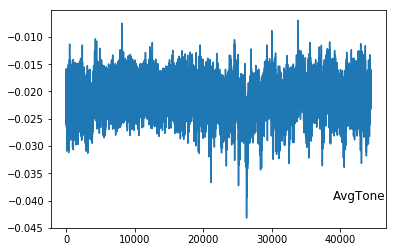

None


In [5]:
print(quickplot(df.loc['2012':'2018'][['AvgTone']]))

In [6]:
goldHourly = pd.read_csv('/home/yuryivz/XAUUSD_Candlestick_1_Hour_BID_05.05.2003-20.01.2018.csv', sep=",")
print(goldHourly.columns)
goldHourly = goldHourly.set_index(goldHourly['Local time'].apply(lambda lt: datetime.datetime.strptime(lt[:16], '%d.%m.%Y %H:%M'))).drop('Local time', 1)
goldHourly.head(5)

Index(['Local time', 'Open', 'Close', 'Volume'], dtype='object')


,Open,Close,Volume
Local time,,,
2003-05-05 00:00:00,340.345,340.345,0.00
2003-05-05 01:00:00,340.345,340.345,0.00
2003-05-05 02:00:00,340.345,340.036,80.44
2003-05-05 03:00:00,340.461,339.987,67.13
2003-05-05 04:00:00,340.134,339.989,48.17


In [7]:
df2 = pd.merge(left=goldHourly,right=df, left_index=True, right_index=True)
future_days = 7
df2['future_close'] = df2['Close'].shift(-24*(future_days))#.rolling('1d').mean()
df2['future_close'] = (df2['future_close'] - df2['Close'])/df2['Close']*100
print(df2['future_close'].head(3))

#normalize outlier
df2.loc['2013-05-08 13:00:00'][['Volume']] = df2.loc['2013-05-08 13:00:00'][['Volume']]/10
start_vals = df2.iloc[0]
def scale(df, cols):
    returnDf = pd.DataFrame({})
    for col in cols:
        shifted = df['{col}'.format(col=col)].shift(1)
        returnDf['{col}'.format(col=col)] = (shifted - df['{col}'.format(col=col)])/shifted*100
    return returnDf   

def unscale(df, cols, restore_first_row):
    returnDf = pd.DataFrame({}).append(df) 
    for col in cols:
        returnDf[col].iloc[0] = restore_first_row[col]
        for i in range(1, len(returnDf['{col}'.format(col=col)].values)):
            prev = returnDf['{col}'.format(col=col)].iloc[i-1]
            returnDf['{col}'.format(col=col)].iloc[i] = prev  - returnDf['{col}'.format(col=col)].iloc[i]*prev/100
    return returnDf

cols_to_scale = ['Open', 'Close']
df2 = pd.merge(left=df2.drop(cols_to_scale, 1), right=scale(df2, cols_to_scale), left_index=True, right_index=True)
#df2 = unscale(df2, ['Close', 'Open'], start_vals)
start_vals

2013-01-01 00:00:00   -1.487845
2013-01-01 01:00:00   -1.436299
2013-01-01 02:00:00   -1.555045
Name: future_close, dtype: float64


Open              1674.746000
Close             1674.771000
Volume              57.600000
GoldsteinScale       0.046217
AvgTone             -0.019299
QuadClass_1          0.670129
QuadClass_2          0.074677
QuadClass_3          0.104716
RootEvent_TF_1       0.663953
future_close        -1.487845
Name: 2013-01-01 00:00:00, dtype: float64

In [8]:
print(df2[['future_close']].head(3))

                     future_close
2013-01-01 00:00:00     -1.487845
2013-01-01 01:00:00     -1.436299
2013-01-01 02:00:00     -1.555045


In [9]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(df, n_in=1, n_out=1, dropnan=False):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = df.shape[1]
    col_names = df.columns.values
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{var}__t-%d' % (i)).format(var=col_names[j]) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{var}__t'.format(var=col_names[j])) for j in range(n_vars)]
        else:
            names += [('{var}__t+%d'.format(var=col_names[j])) % (i) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
#Add past hours of AvgTone and GoldsteinScale
time_steps_back = 168*3

df2['Volume'] = df2['Volume'].fillna(1).apply(lambda v: (0 if v < 1 else math.log(v))/10)

week_dict = {0: 0, 1: 0.2, 2: 0.4, 3: 0.6, 4: 0.4, 5: 0.2, 6: 0}

df2['FromMonday'] = df2.index.map(lambda w: w.weekday()/10)
df2['Weekday'] = df2['FromMonday'].apply(lambda w: week_dict[w*10])

base_features = list(df2.columns.values)
base_features.remove('future_close')

df2 = pd.merge(left=df2,right= series_to_supervised(df2.drop('future_close', 1), n_in=time_steps_back, n_out=1), left_index=True, right_index=True)

df2.columns

Index(['Volume', 'GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2',
       'QuadClass_3', 'RootEvent_TF_1', 'future_close', 'Open', 'Close',
       ...
       'GoldsteinScale__t', 'AvgTone__t', 'QuadClass_1__t', 'QuadClass_2__t',
       'QuadClass_3__t', 'RootEvent_TF_1__t', 'Open__t', 'Close__t',
       'FromMonday__t', 'Weekday__t'],
      dtype='object', length=5567)

In [11]:
df2.reset_index().drop('index', 1).head(5)

,Volume,GoldsteinScale,AvgTone,QuadClass_1,QuadClass_2,QuadClass_3,RootEvent_TF_1,future_close,Open,Close,...,GoldsteinScale__t,AvgTone__t,QuadClass_1__t,QuadClass_2__t,QuadClass_3__t,RootEvent_TF_1__t,Open__t,Close__t,FromMonday__t,Weekday__t
0,0.405352,0.046217,-0.019299,0.670129,0.074677,0.104716,0.663953,-1.487845,NaN,NaN,...,0.046217,-0.019299,0.670129,0.074677,0.104716,0.663953,NaN,NaN,0.1,0.2
1,0.000000,0.039041,-0.017573,0.606682,0.104155,0.092645,0.700168,-1.436299,-0.015166,-0.013674,...,0.039041,-0.017573,0.606682,0.104155,0.092645,0.700168,-0.015166,-0.013674,0.1,0.2
2,0.000000,0.058883,-0.015837,0.653187,0.130862,0.110924,0.651783,-1.555045,0.000000,0.000000,...,0.058883,-0.015837,0.653187,0.130862,0.110924,0.651783,0.000000,0.000000,0.1,0.2
3,0.000000,-0.015483,-0.026073,0.421392,0.123245,0.102190,0.699888,-1.476239,0.000000,0.000000,...,-0.015483,-0.026073,0.421392,0.123245,0.102190,0.699888,0.000000,0.000000,0.1,0.2
4,0.000000,0.045017,-0.018113,0.660865,0.097979,0.088714,0.688658,-1.562806,0.000000,0.000000,...,0.045017,-0.018113,0.660865,0.097979,0.088714,0.688658,0.000000,0.000000,0.1,0.2


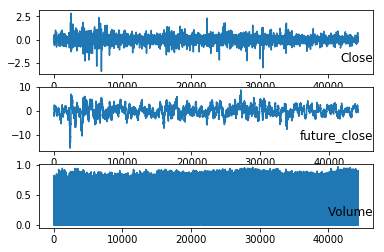

None


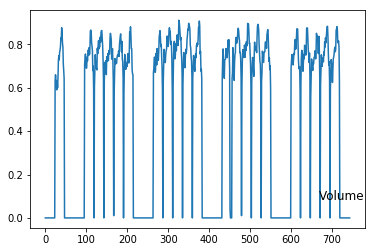

None


In [12]:
print(quickplot(df2[['Close','future_close' , 'Volume']]))
print(quickplot(df2['2015-01'][['Volume']]))

In [13]:
pretrainDf = df2
start_date = datetime.datetime.strptime('2015-02-01', "%Y-%m-%d")# + datetime.timedelta(hours = 168)
end_date = '2017-06-01'
val_end_date = '2018-01-01'
prediction_columns = ['future_close']
print(prediction_columns)

train_y_df = pretrainDf.loc[start_date:end_date][prediction_columns]
test_y_df = pretrainDf.loc[end_date:val_end_date][prediction_columns]
test_y_df.head(5)

['future_close']


,future_close
2017-06-01 00:00:00,1.426364
2017-06-01 01:00:00,1.254160
2017-06-01 02:00:00,1.435346
2017-06-01 03:00:00,1.373036
2017-06-01 04:00:00,1.373405


In [54]:
print(df2.filter(regex='future_close.*').columns)

Index(['future_close'], dtype='object')


### Train and test

In [14]:
%%capture
train = pretrainDf.loc[start_date:end_date]
test = pretrainDf.loc[end_date:val_end_date]

def convertX(tr=train, te=test):
    train_panel ={}
    test_panel = {}
    for i in range(1, time_steps_back+1):
        r = '__t-{i}($|\D)'.format(i=i)

        df_temp_train = tr.filter(regex=r)
        df_temp_test = te.filter(regex=r)
        df_temp_train.columns = df_temp_test.columns = tr.filter(regex=r).columns.map(lambda c: c[:len(c) - (len(str(i)) + 4)])

        colName = 'a' + str(i) if i<10 else 'b' + str(i) if i<100 else 'c' + str(i)
        train_panel[colName] = df_temp_train
        test_panel[colName] = df_temp_test

    train_panel = pd.Panel(train_panel).swapaxes(0, 1, copy=True).swapaxes(1, 2, copy=True)
    test_panel = pd.Panel(test_panel).swapaxes(0, 1, copy=True).swapaxes(1, 2, copy=True)
    print(train_panel)    
    return (train_panel.values, test_panel.values)

train_X, test_X = convertX()
train_y = train_y_df.values
test_y = test_y_df.values

In [15]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
test_y
train_X.dtype

(20475, 11, 504) (20475, 1)
(5175, 11, 504) (5175, 1)


dtype('float64')

In [16]:
print(base_features)
opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model = Sequential()
model.add(LSTM(len(base_features)*10, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(len(prediction_columns), activation='linear'))
model.compile(loss='mse', optimizer=opt, metrics=['mse', 'acc'])

['Volume', 'GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2', 'QuadClass_3', 'RootEvent_TF_1', 'Open', 'Close', 'FromMonday', 'Weekday']


In [17]:
# Plotting callback used from Kavanaugh Latiolais's code, https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
        
        clear_output(wait=True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

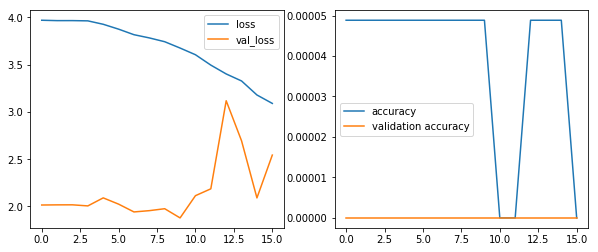

20475/20475 [==============================] - 20s 981us/step - loss: 3.0893 - mean_squared_error: 3.0893 - acc: 0.0000e+00 - val_loss: 2.5433 - val_mean_squared_error: 2.5433 - val_acc: 0.0000e+00
Epoch 17/50
19000/20475 [==========================>...] - ETA: 1s - loss: 2.9673 - mean_squared_error: 2.9673 - acc: 0.0000e+00

KeyboardInterrupt: 

In [18]:
checkpoint = ModelCheckpoint("weights-3.hdf5", monitor='val_loss', verbose=3, save_best_only=True, mode='min')
stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=3, mode='auto')

callbacks_list = [checkpoint, plot_losses]#, stopping]  

history = model.fit(train_X, train_y, epochs=50, batch_size=500, validation_data=(test_X, test_y), verbose=1, shuffle=True, callbacks = callbacks_list)

In [226]:
model.load_weights("weights-3.hdf5")

In [19]:
def invest_path_sim(deltas, wallet, prices, c_sell_func = (lambda x: 1/(1 + math.e**(-abs(x)/10000))), g_sell_func = (lambda x: 1)):
    wallet_hist = [wallet]
    trans_fee = 0
    start_date = predicted_weekly_deltas[0][0]
    end_date = predicted_weekly_deltas[-1][1]
    
    def buyorsell(delta, wallet):
        ex_rate = prices.loc[delta[0]]
        stored = wallet[:]
        if (delta[2] > 0) & (stored[0] > 0): #BUY, only if we have cash
            wallet = (stored[0] - stored[0]*c_sell_func(delta[2]) - trans_fee, stored[1] + stored[0]*c_sell_func(delta[2])/ex_rate)
        elif (delta[2] < 0) & (stored[1] > 0): #SELL, only if we have commodity
            wallet = (stored[0] + stored[1]*g_sell_func(delta[2])*ex_rate - trans_fee, stored[1] - stored[1]*g_sell_func(delta[2]))
        return wallet
            
    for delta in deltas:
        wallet_hist.append(buyorsell(delta, wallet_hist[-1]))
        
    return wallet_hist

(100.0, 0.0)


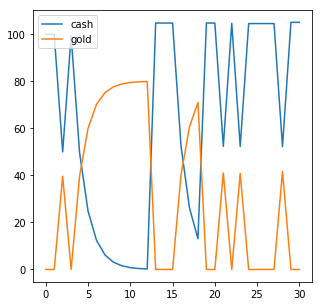

(105.03561054790185, 0.0)


In [20]:
# make a prediction
scale_factor = 0.02

yhat = pd.DataFrame(model.predict(test_X))
yhat.columns = prediction_columns
yhat = yhat.set_index(test.index)
yhat = yhat*scale_factor

pred_start_date = yhat.index[0]
pred_end_date = yhat.index[-1] 

pred_appended = pd.DataFrame({}).append(pretrainDf)
col = pd.concat([pred_appended['future_close'].loc[:(pred_start_date - datetime.timedelta(hours=1))], yhat['future_close']], axis=0)
pred_appended = pred_appended.loc[:pred_end_date]
pred_appended['prediction'] = col.values

yhat = unscale(pred_appended, ['Close', 'Open'], start_vals)
yhat['pred2'] = ((yhat['prediction']/100)*yhat['Close']) + yhat['Close']

tempdf = pd.DataFrame({}).append(yhat).drop('prediction', 1).rename(columns={'pred2': 'prediction'})
yhat['prediction'][:pred_start_date] = yhat['pred2'][:pred_start_date]

w = 168
diff = (pred_end_date - pred_start_date)
total_steps = int(diff.days * 24 + diff.seconds // 3600)

predicted_weekly_deltas = [] #tuple3(start date, end date, difference in predicted price)   

for i in range(0, math.ceil(total_steps/w)):
    s = pred_start_date + datetime.timedelta(hours=w*i)
    e = pred_start_date + datetime.timedelta(hours=w*(i+1))
    
    yhat[s:e] = unscale(yhat[s:e], ['prediction'], tempdf.loc[s])
    
    try:
        predicted_weekly_deltas.append((s, e, (yhat['prediction'].loc[e] - yhat['prediction'].loc[s])))
    except:
        break
        
yhat['future_close'] = ((yhat['future_close']/100)*yhat['Close']) + yhat['Close']
#print(yhat[['Close', 'prediction', 'future_close']][:-168].tail(10))

wallet = (100.0, 0.0)
print(wallet)

invest_seq = invest_path_sim(predicted_weekly_deltas, wallet, yhat['future_close'])
plt.figure(figsize=(5,5))
plt.plot([c[0] for c in invest_seq], label='cash')
plt.plot([g[1]*1000 for g in invest_seq], label='gold')
plt.legend(loc='upper left')
plt.show()
print(invest_seq[-1])


In [21]:
for i in invest_seq:
    print(i)

(100.0, 0.0)
(100.0, 0.0)
(49.96454728674825, 0.039617857775475038)
(99.354189300401984, 0.0)
(49.666391232225045, 0.039733995197304896)
(24.814827951812926, 0.059985920867562451)
(12.401686964217019, 0.070168296761859802)
(6.1996250993404738, 0.075163389397978383)
(3.0979681935718841, 0.077622566589138783)
(1.5482222259276641, 0.078846566904780618)
(0.7737006006866447, 0.079453187005346745)
(0.38683788471956526, 0.079754519974122459)
(0.19332122501574345, 0.079904460707849734)
(104.74599083187658, 0.0)
(104.74599083187658, 0.0)
(104.74599083187658, 0.0)
(52.36101323598573, 0.040265132460229357)
(26.145924449985039, 0.060690903974419973)
(13.067858621465193, 0.07094972317954186)
(104.75412834441492, 0.0)
(104.75412834441492, 0.0)
(52.331375997122066, 0.040990148921459628)
(104.6180820401446, 0.0)
(52.305826133045535, 0.040810890059609771)
(104.51760562881782, 0.0)
(104.51760562881782, 0.0)
(104.51760562881782, 0.0)
(104.51760562881782, 0.0)
(52.226339296593537, 0.041700605303818736)
(1

## Future Predictions

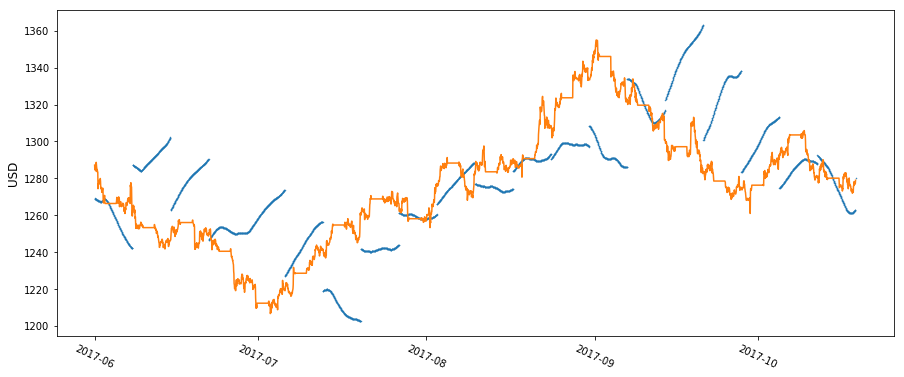

In [240]:
offset = 0
начало = pred_start_date + datetime.timedelta(weeks = 0)
конец = начало + datetime.timedelta(weeks = 20)
i = yhat.loc[начало:конец].index[:]
t = yhat[i[0]:i[-1]]['prediction']
p = yhat[i[0]:i[-1]]['future_close']
plt.figure(figsize=(15,6))
plt.xticks(rotation=-25)
plt.ylabel('USD', fontsize=12)
plt.plot(i, t + offset, linestyle='None',marker='.', markersize=1)
plt.plot(i, p)
plt.show()

In [164]:
print(yhat['future_close'][pred_start_date], ' ' , yhat['future_close'][pred_end_date])
print(500/yhat['future_close'][pred_start_date]*yhat['future_close'][pred_end_date])

1287.132   1320.231
512.857655625


In [30]:
print(pred_start_date, pred_end_date)

2017-06-01 00:00:00 2018-01-01 23:00:00
